In [1]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [2]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs))
    dpi = math.log2(num)
    return - npi/dpi

def fairnessnorm(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    
    fn = (npi/dpi - 1/num) / (1 - 1/num)
    
    return fn

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairnessnorm(values_list[1]))

0.7556018366014379
0.8056472313898059


In [3]:
import os

#PATH = "../blockchainnode/db_nodes"
PATH = "/mnt/c/Temp/PoS_20221125_152153"
fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
fdbs.sort()
print(fdbs)

['/mnt/c/Temp/PoS_20221125_152153/7031.db', '/mnt/c/Temp/PoS_20221125_152153/7032.db', '/mnt/c/Temp/PoS_20221125_152153/7033.db', '/mnt/c/Temp/PoS_20221125_152153/7034.db', '/mnt/c/Temp/PoS_20221125_152153/7035.db', '/mnt/c/Temp/PoS_20221125_152153/7036.db', '/mnt/c/Temp/PoS_20221125_152153/7037.db', '/mnt/c/Temp/PoS_20221125_152153/7038.db']


[28, 24, 20, 19, 23, 18, 15, 37] 184
[16, 29, 29, 18, 30, 18, 27, 16] 183
Fairness Proof 0.9159369527145359
Fairness Verification 0.9271815189954309
Entropy Proof 0.9820425162114539
Entropy Verification 0.9834320440983392


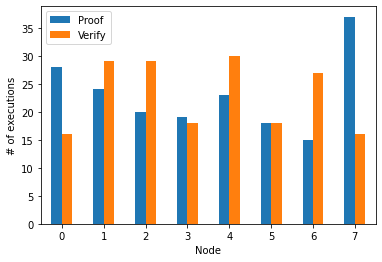

In [12]:
# Count chart for proof and verify
from matplotlib import pyplot as plt
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof, sum(proof))

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif, sum(verif))

ch_list = [proof, verif]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("# of executions")
plt.savefig('Num_Prover_Verifier.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairnessnorm(proof))
print('Fairness Verification', fairnessnorm(verif))

print('Entropy Proof', entropynorm(proof))
print('Entropy Verification', entropynorm(verif))




[16.404361, 5.623605958333333, 4.035757, 5.100337, 3.7959746521739133, 5.881059333333333, 13.686673599999999, 6.853412648648648]
[7160.477591625, 6944.836372586206, 6480.079092103448, 7389.829765111111, 6343.100727766667, 6948.459725277778, 6966.981564592592, 6975.0144684375]
[567.620390125, 532.8881066206897, 618.9745032068965, 682.3559763888888, 696.9667195666667, 704.5029718333334, 651.4574326666666, 604.465607375]
Avg Proof[msec] 7.672647649061154
Avg Verif Fwd[msec] 6901.097413437537
Avg Verif Back[msec] 632.4039634728928


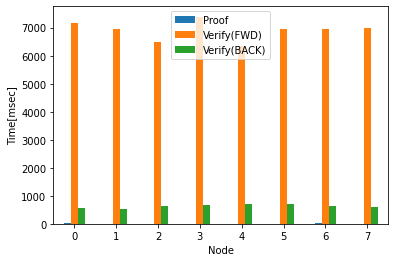

In [5]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    verifrev.append(df['timeverifrev'].mean()/unit)
print(veriffwd)
print(verifrev)

ch_list = [proof, veriffwd, verifrev]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify(FWD)', 'Verify(BACK)']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Time[msec]")

plt.savefig('Avg_Time_Proof_Verify.png', dpi=300, bbox_inches='tight')

print('Avg Proof[msec]', sum(proof)/len(proof))
print('Avg Verif Fwd[msec]', sum(veriffwd)/len(veriffwd))
print('Avg Verif Back[msec]', sum(verifrev)/len(verifrev))


[904.8362857142857, 900.9995, 677.0912, 979.4023157894737, 781.3537391304349, 985.2946666666667, 1196.3682666666666, 974.2361081081082]
Avg size of proof 924.9477602594544


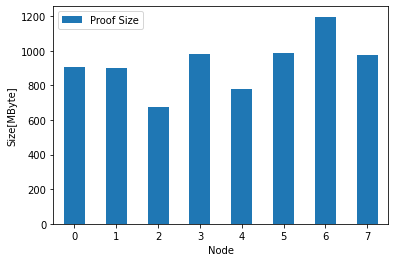

In [6]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Size[MByte]")
plt.savefig('Avg_Size_Proof.png', dpi=300, bbox_inches='tight')

print('Avg size of proof', sum(proof)/len(proof))


                                                     0    1
0    00000000000000000006d8469efdd8b316d0a52c6bc7c2...    2
1    000000000000000000030b1003247f1f2b061c77d38ce5...   13
2    00000000000000000006d8469efdd8b316d0a52c6bc7c2...    2
3    00000000000000000006e12037e999d2a1abf3353ca95e...   17
4    000000000000000000086b49b8ef039c23d0d63fe9750d...   37
..                                                 ...  ...
179  00000000000000000006d2b5ededa6a331f53745a393bd...   53
180  00000000000000000005af0e81cf01e121086d77bea4c4...  194
181  000000000000000000036aa2a513e139ccde4eee105887...  272
182  00000000000000000003a5fd06669daca29617f1e8969e...  253
183  000000000000000000040a6b1068557a76781b829a8da3...   69

[184 rows x 2 columns]


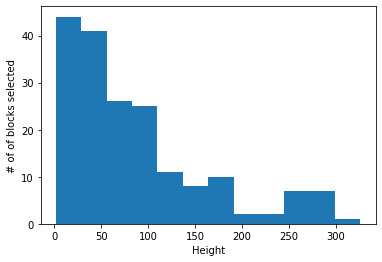

In [18]:
# List up proof block and show it in the time order 
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
hash = []
for i, df in enumerate(dfs):
    for s in df['proofblock']:        
        hash.append(s)
# print(hash)

height = []
for i, df in enumerate(dfs):
    for h in df['proofheight']:        
        height.append(h)
# print(height)

ch_list = [hash, height]
bdf = pd.DataFrame(ch_list).transpose()
print(bdf)

bdf.columns = ['Hash', 'Height']
bdf = bdf.sort_values(by=['Height'])
bdf2 = bdf.groupby(['Height'])['Height'].count().reset_index(name="Count")

# pd.set_option('display.max_rows', None)
# bdf2 = bdf2.set_index('Height')
# bdf2 = bdf2.reindex(list(range(bdf2.index.min(),bdf2.index.max()+1)),fill_value=0)
# print(bdf2)
# ax = bdf2.plot.line(rot=0)

bdf = pd.DataFrame([height]).transpose()
ax = bdf.plot.hist(bins=12, label='Count')
ax.get_legend().remove()
# df.plot(legend=False)

plt.xlabel("Height")
plt.ylabel("# of of blocks selected")

plt.savefig('Proof_Blocks.png', dpi=300, bbox_inches='tight')



In [47]:
import numpy as np
 
def cal_evenness1(vdf, vmax):
    vdf['weight'] = (vmax - vdf['Height'])
    vdf['norm_cnt'] = vdf['Count']/vdf['weight']
    values = vdf['norm_cnt'].to_list()
    nf = fairnessnorm(values[:int(len(values)/2)])
    ne = entropynorm(values[:int(len(values)/2)])
    print(nf, ne)
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    
def cal_evenness2(vdf, vmax):
    vdf['norm_cnt'] = vdf['Count']*vdf['Height']
    values = vdf['norm_cnt'].to_list()
    nf = fairnessnorm(values[:int(vmax/2)])
    ne = entropynorm(values[:int(vmax/2)])
    print(nf, ne)

def cal_evenness3(vdf, vmax):
    vdf['weight'] = 1 - np.exp(-vdf['Height']/50) 
    vdf['norm_cnt'] = vdf['Count']*vdf['weight']  
    values = vdf['norm_cnt'].to_list()
    
    nf = fairnessnorm(values[:int(vmax/2)])
    ne = entropynorm(values[:int(vmax/2)])
    print(nf, ne)
    print(vdf)
    
cal_evenness1(bdf2, 360)
cal_evenness2(bdf2, 360)
cal_evenness3(bdf2, 360)


0.718461218061553 0.9587007769730387
0.6904139641425647 0.9611661528970377
0.5925114625550457 0.9350450971508641
0.6678854675085133 0.9583103824549016
     Height  Count  norm_cnt    weight
0         2      4  0.156842  0.039211
1         3      1  0.058235  0.058235
2         4      3  0.230651  0.076884
3         5      3  0.285488  0.095163
4         6      2  0.226159  0.113080
..      ...    ...       ...       ...
98      278      1  0.996151  0.996151
99      279      1  0.996227  0.996227
100     282      2  1.992894  0.996447
101     283      1  0.996517  0.996517
102     326      1  0.998526  0.998526

[103 rows x 4 columns]
